In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from cdlib import algorithms, viz, evaluation
# import tensorflow as tf

In [2]:
with open('../../GCN/evaluation_20189/pred_list.pkl', 'rb') as f:
    pred_list= pickle.load(f) 

In [3]:
pred_list[0].shape

torch.Size([625, 2])

In [4]:
def pred_list_to_adj(pred, country_num=25):
    adj = np.zeros([country_num, country_num])
    for source in range(country_num):
        for target in range(country_num):
            if(source==target):
                continue
            if(pred[country_num*source + target][0] < pred[country_num*source + target][1]):
                adj[source,target] = +1
    return adj

In [5]:
travel_df = pd.read_csv('../csv/global_travel_df.csv')
countries = travel_df['node'].unique().T

In [6]:
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [7]:
label_dict = dict(zip(np.char.mod('%d', range(226)), countries[new_order]))
label_dict = dict(zip(range(30), countries[new_order]))

In [8]:
label_dict

{0: 'US',
 1: 'GB',
 2: 'FR',
 3: 'ES',
 4: 'IT',
 5: 'DE',
 6: 'MX',
 7: 'CA',
 8: 'JP',
 9: 'NL',
 10: 'BR',
 11: 'TH',
 12: 'ID',
 13: 'MY',
 14: 'SG',
 15: 'BE',
 16: 'AE',
 17: 'AU',
 18: 'CH',
 19: 'PH',
 20: 'IE',
 21: 'PT',
 22: 'AR',
 23: 'TR',
 24: 'RU',
 25: 'KW',
 26: 'CN',
 27: 'IN',
 28: 'HK',
 29: 'AT'}

In [9]:
with open('../pkl/global_weekly_sorted_tensor2.pkl', 'rb') as f:
    travel_tensors_raw= pickle.load(f) 

In [10]:
int(np.sqrt(pred_list[0].shape[0]))

25

In [11]:
country_cutline = int(np.sqrt(pred_list[0].shape[0])) # 69, 70 give None homogeneity
travel_tensors = travel_tensors_raw[:,0:country_cutline,0:country_cutline]

In [12]:
adj_list = []
interval = 50 # 26 * 4 weeks = 2 year,
for i in range(interval):
    ajm = np.sum(travel_tensors[4*i:4 + 4*i][:,0:country_cutline,0:country_cutline], axis=0)
    adj_list.append(ajm)

In [13]:
pred_density = []
pred_adj = []
test_interval = len(pred_list)
for i in range(test_interval):
    adj = pred_list_to_adj(pred_list[i])
    den = np.sum(adj>0)/(country_cutline*(country_cutline-1))
    pred_density.append(den)
    pred_adj.append(adj)
    print(den)
pred_adj = np.array(pred_adj)

0.88
0.7033333333333334
0.7866666666666666
0.705
0.945
0.9783333333333334
0.985
0.985
0.9366666666666666
0.9583333333333334
0.9733333333333334
0.62
0.81
0.49
0.245
0.10666666666666667
0.07166666666666667
0.3516666666666667
0.115
0.3383333333333333


In [14]:
real_density = [] 
for i in range(test_interval):
    den = np.sum(adj_list[-1*test_interval+i]>0)/(country_cutline*(country_cutline-1))
    real_density.append(den)
    print(den)

0.39166666666666666
0.3883333333333333
0.4216666666666667
0.42
0.44333333333333336
0.49166666666666664
0.465
0.49833333333333335
0.5116666666666667
0.4266666666666667
0.43833333333333335
0.37166666666666665
0.36333333333333334
0.23833333333333334
0.18
0.17833333333333334
0.25
0.23
0.21
0.17


In [15]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')
# week_slices[0::4]
week_slices

DatetimeIndex(['2016-01-10', '2016-01-17', '2016-01-24', '2016-01-31',
               '2016-02-07', '2016-02-14', '2016-02-21', '2016-02-28',
               '2016-03-06', '2016-03-13',
               ...
               '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
               '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27',
               '2019-11-03', '2019-11-10'],
              dtype='datetime64[ns]', length=201, freq='W-SUN')

In [16]:
# from sklearn.preprocessing import normalize
def scale(pred_density):
    return (pred_density - np.min(pred_density))/(np.max(pred_density)-np.min(pred_density))

In [17]:
week_slices[0::4][-1*test_interval:]

DatetimeIndex(['2018-05-27', '2018-06-24', '2018-07-22', '2018-08-19',
               '2018-09-16', '2018-10-14', '2018-11-11', '2018-12-09',
               '2019-01-06', '2019-02-03', '2019-03-03', '2019-03-31',
               '2019-04-28', '2019-05-26', '2019-06-23', '2019-07-21',
               '2019-08-18', '2019-09-15', '2019-10-13', '2019-11-10'],
              dtype='datetime64[ns]', freq='4W-SUN')

In [18]:
def moving_avg(pred_density, window_size = 3):
    numbers_series = pd.Series(scale(pred_density))
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    without_nans = moving_averages_list[window_size - 1:]
#     plt.plot(without_nans)
#     return moving_averages_list
    return without_nans

In [19]:
moving_averages_list = moving_avg(pred_density)

In [20]:
moving_avg(pred_density)

[0.7864963503649635,
 0.7226277372262775,
 0.8108272506082725,
 0.8807785888077859,
 0.9829683698296838,
 0.9975669099756693,
 0.9823600973236011,
 0.9726277372262775,
 0.9683698296836983,
 0.8527980535279807,
 0.7986618004866181,
 0.6222627737226277,
 0.48540145985401467,
 0.22871046228710468,
 0.07603406326034068,
 0.1149635036496351,
 0.11800486618004874,
 0.21532846715328477]

In [21]:
len(pred_density)

20

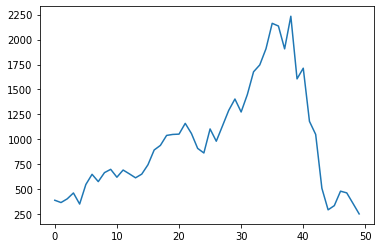

In [22]:
plt.plot(np.sum(np.sum(np.array(adj_list), 1),1))

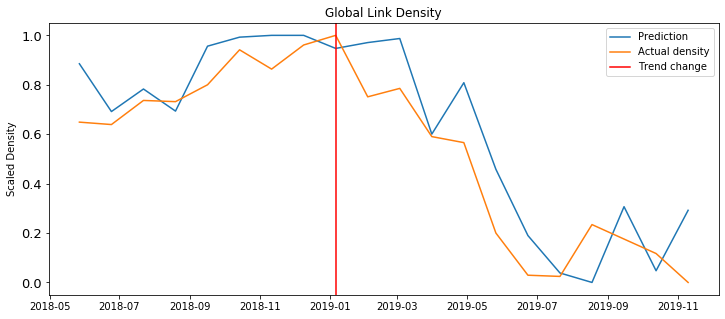

In [45]:
plt.figure(figsize=(12,5))
xaxis = week_slices[0::4][-1*test_interval:]
plt.plot(xaxis, scale(pred_density), label = "Prediction")
plt.yticks(fontsize=13)
# plt.plot(xaxis[1:-1], scale(moving_averages_list), label = "Moving Avg Prediction")
plt.plot(xaxis, scale(real_density), label = "Actual density")

plt.axvline(x=xaxis[-12], linestyle='-', color='red', label="Trend change")
plt.title("Global Link Density")
plt.ylabel("Scaled Density")
plt.legend()

In [24]:
week_slices[0::4][-1*test_interval:]

DatetimeIndex(['2018-05-27', '2018-06-24', '2018-07-22', '2018-08-19',
               '2018-09-16', '2018-10-14', '2018-11-11', '2018-12-09',
               '2019-01-06', '2019-02-03', '2019-03-03', '2019-03-31',
               '2019-04-28', '2019-05-26', '2019-06-23', '2019-07-21',
               '2019-08-18', '2019-09-15', '2019-10-13', '2019-11-10'],
              dtype='datetime64[ns]', freq='4W-SUN')

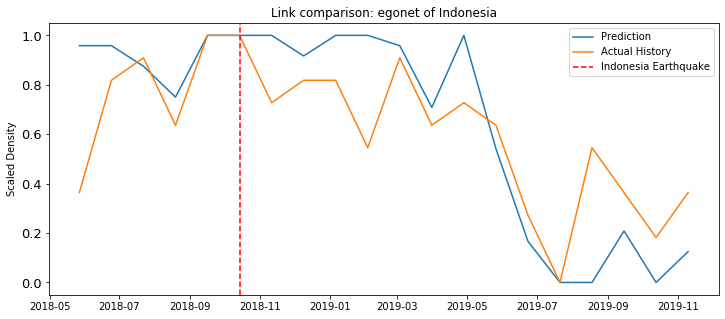

In [43]:
country_num = 12

outd_pred = np.sum(pred_adj[:,country_num,:],axis=1)
ind_pred = np.sum(pred_adj[:,:,country_num],axis=1)
total_link_pred = outd_pred + ind_pred

adj_array = np.array(adj_list)
outd_real = np.sum(adj_array[:,country_num,:]>0,axis=1)
ind_real = np.sum(adj_array[:,:,country_num]>0,axis=1)
total_link_real = outd_real + ind_real

plt.figure(figsize=(12,5))
plt.yticks(fontsize =13)
xaxis = week_slices[0::4][-1*test_interval:]
plt.plot(xaxis, scale((outd_pred[0:])), label = "Prediction")
# plt.plot(xaxis[0:8], scale((outd_pred[0:]))[0:8], label = "Prediction ind",linestyle='--')
plt.plot(xaxis, scale((outd_real[-1*test_interval:])), label = "Actual History")
# plt.plot(xaxis[0:8], scale((outd_real[-1*test_interval:]))[0:8], label = "Actual History ind",linestyle='--')

plt.axvline(x=xaxis[-15], linestyle='--', color='red', label="Indonesia Earthquake")
# plt.axvline(x=xaxis[1], linestyle='dotted', color='purple', label="Maximum gap")
plt.ylabel("Scaled Density")
# plt.title("Link comparison: neighbors of "+label_dict[country_num])
plt.title("Link comparison: egonet of Indonesia")
plt.legend()

In [26]:
with open('../../GCN/edge_pred20189/pred_list.pkl', 'rb') as f:
    pred_edge= pickle.load(f) 

In [27]:
with open('../../GCN/edge_pred20189/idx_list.pkl', 'rb') as f:
    edge_idx= pickle.load(f) 

In [28]:
time = -1

In [29]:
def update_pred(time=-1):
    local_pred = copy.deepcopy(pred_adj[time]) 
    edge_adj = np.zeros([country_cutline,country_cutline])
    for i in range(1,edge_idx[time].shape[1]):
            r = edge_idx[time][0][i]
            c = edge_idx[time][1][i]
            if(pred_edge[time][i][0] < pred_edge[time][i][1]):
                local_pred[r][c] = local_pred[r][c]*3
    return local_pred

In [30]:
import copy
predG_list = []
predWAdj_list = []
predcoms_list = []
length = len(pred_adj)
for i in range(length):
    adj = update_pred(time=(-1*length+i))
    predWAdj_list.append(adj)
    temp_G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)
    temp_G = nx.relabel_nodes(temp_G, label_dict) 
    predG_list.append(temp_G)
    predcoms_list.append(algorithms.leiden(temp_G, weights='weight'))

predWAdj_list = np.array(predWAdj_list)

In [31]:
print(xaxis[-16], xaxis[-15])

2018-09-16 00:00:00 2018-10-14 00:00:00


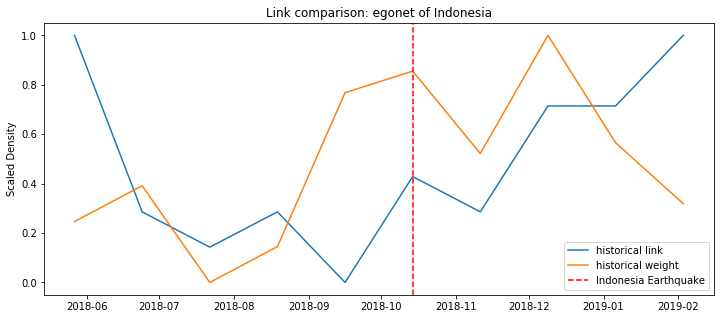

In [32]:
country_num = 12

# outw_pred = np.sum(predWAdj_list[:,country_num,:],axis=1)
# inw_pred = np.sum(predWAdj_list[:,:,country_num],axis=1)
# total_weight_pred = outw_pred + inw_pred

adj_array = np.array(adj_list)
outd_real = np.sum(adj_array[:,country_num,:]>0,axis=1)
ind_real = np.sum(adj_array[:,:,country_num]>0,axis=1)
total_link_real = outd_real + ind_real

outw_real = np.sum(adj_array[:,country_num,:],axis=1)
inw_real = np.sum(adj_array[:,:,country_num],axis=1)
total_weight_real = outw_real + inw_real

plt.figure(figsize=(12,5))
xaxis = week_slices[0::4][-1*test_interval:]
plt.plot(xaxis[0:10], scale((total_link_real[0:])[0:10]), label = "historical link")
# plt.plot(xaxis[0:8], scale((total_weight_pred[0:]))[0:8], label = "Weight Prediction")
plt.plot(xaxis[0:10], scale((total_weight_real[-1*test_interval:])[0:10]), label = "historical weight")
# plt.plot(xaxis[0:8], scale((total_weight_real[-1*test_interval:]))[0:8], label = "historical weight")

plt.axvline(x=xaxis[-15], linestyle='--', color='red', label="Indonesia Earthquake")
plt.ylabel("Scaled Density")
plt.title("Link comparison: egonet of Indonesia")
plt.legend()

In [33]:
country_num = 24

In [34]:
outd_pred = np.sum(pred_adj[:,country_num,:],axis=1)
ind_pred = np.sum(pred_adj[:,:,country_num],axis=1)
total_link_pred = outd_pred + ind_pred

In [35]:
adj_array = np.array(adj_list)
outd_real = np.sum(adj_array[:,country_num,:]>0,axis=1)
ind_real = np.sum(adj_array[:,:,country_num]>0,axis=1)
total_link_real = outd_real + ind_real

In [36]:
outw_real = np.sum(adj_array[:,country_num,:],axis=1)
inw_real = np.sum(adj_array[:,:,country_num],axis=1)
total_weight_real = outw_real + inw_real

In [37]:
print(xaxis[1],xaxis[2])

2018-06-24 00:00:00 2018-07-22 00:00:00


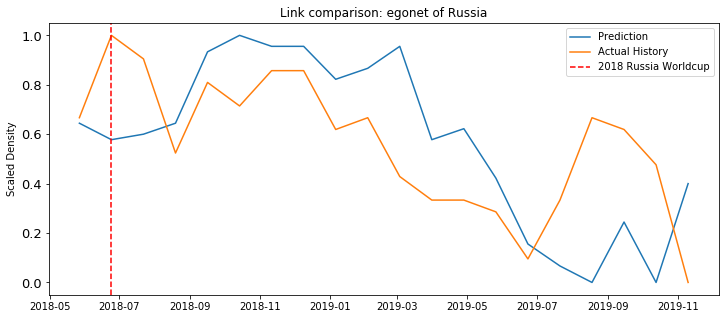

In [42]:
plt.figure(figsize=(12,5))
xaxis = week_slices[0::4][-1*test_interval:]
plt.plot(xaxis, scale((total_link_pred[0:])), label = "Prediction")
plt.yticks(fontsize =13)
# plt.plot(xaxis, total_weight_real[-1*test_interval:], label = "Actual weights")
plt.plot(xaxis, scale((total_link_real[-1*test_interval:])), label = "Actual History")

plt.axvline(x=xaxis[1], linestyle='--', color='red', label="2018 Russia Worldcup")
# plt.axvline(x=xaxis[1], linestyle='dotted', color='purple', label="Maximum gap")
plt.ylabel("Scaled Density")
# plt.title("Link comparison: neighbors of "+label_dict[country_num])
plt.title("Link comparison: egonet of Russia")
plt.legend()

In [726]:
print(xaxis[1], xaxis[2])

2018-06-24 00:00:00 2018-07-22 00:00:00


In [727]:
# country_num = 24
# min_range = 0
# max_range = -1

# outw_pred = np.sum(predWAdj_list[:,country_num,:],axis=1)
# inw_pred = np.sum(predWAdj_list[:,:,country_num],axis=1)
# total_weight_pred = outw_pred + inw_pred

# adj_array = np.array(adj_list)
# outd_real = np.sum(adj_array[:,country_num,:]>0,axis=1)
# ind_real = np.sum(adj_array[:,:,country_num]>0,axis=1)
# total_link_real = outd_real + ind_real

# plt.figure(figsize=(12,5))
# xaxis = week_slices[0::4][-1*test_interval:]
# plt.plot(xaxis[0:max_range], scale((total_link_pred[0:]))[0:max_range], label = "Link Prediction")
# # plt.plot(xaxis[0:max_range], scale((total_weight_pred[0:]))[0:max_range], label = "Weight Prediction")
# plt.plot(xaxis[0:max_range], scale((total_link_real[-1*test_interval:]))[0:max_range], label = "Actual History")

# plt.axvline(x=xaxis[2], linestyle='--', color='red', label="Indonesia Earthquake")
# plt.ylabel("Scaled Density")
# plt.title("Link comparison: egonet of Russia")
# plt.legend()

In [676]:
# plt.figure(figsize=(12,5))
# xaxis = week_slices[0::4][-20:]
# plt.plot(xaxis[1:-1], scale(moving_avg(outd_pred[0:])), label = "Moving Avg ind Prediction")
# # plt.plot(xaxis, total_weight_real[-10:], label = "Actual weights")
# plt.plot(xaxis[1:-1], scale(moving_avg(outd_real[-20:])), label = "Moving Avg in actual density")
# plt.axvline(x=xaxis[-14], linestyle='--', color='red', label="Indonesia EarthQuake")
# # plt.axvline(x=xaxis[1], linestyle='dotted', color='purple', label="Maximum gap")
# plt.ylabel("Scaled Density")
# plt.title("Link comparison: neighbors of "+label_dict[country_num])
# # plt.title("Link comparison: egonet of Russia")
# plt.legend()

In [677]:
# update_pred(time=-1)
predG_list = []
predWAdj_list = []
predcoms_list = []
length = len(pred_adj)
for i in range(length):
    adj = update_pred(time=(-1*length+i))
    predWAdj_list.append(adj)
    temp_G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)
    temp_G = nx.relabel_nodes(temp_G, label_dict) 
    predG_list.append(temp_G)
    predcoms_list.append(algorithms.leiden(temp_G, weights='weight'))

predWAdj_list = np.array(predWAdj_list)

In [678]:
# predG_list = []
# predcoms_list = []
# for i in range(len(pred_adj)):
#     temp_G = nx.from_numpy_matrix(pred_adj[i], create_using=nx.DiGraph)
#     temp_G = nx.relabel_nodes(temp_G, label_dict) 
#     predG_list.append(temp_G)
#     predcoms_list.append(algorithms.leiden(temp_G, weights='weight'))

In [679]:
realG_list = []
realcoms_list = []
for i in range(len(pred_adj)):
    temp_G = nx.from_numpy_matrix(adj_list[-length+i], create_using=nx.DiGraph)
    temp_G = nx.relabel_nodes(temp_G, label_dict) 
    realG_list.append(temp_G)
    realcoms_list.append(algorithms.leiden(temp_G, weights='weight'))

In [680]:
print(len(predG_list))
print(len(realG_list))

20
20


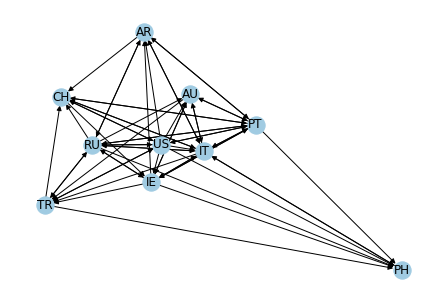

In [681]:
G = nx.ego_graph(predG_list[2], 'RU')
pos = nx.spring_layout(G)
# colors = range(1)
nx.draw(G, pos, node_color='#A0CBE2', 
        radius = 1,
#         edge_color=colors,
        width=1, edge_cmap=plt.cm.Blues, with_labels=True)

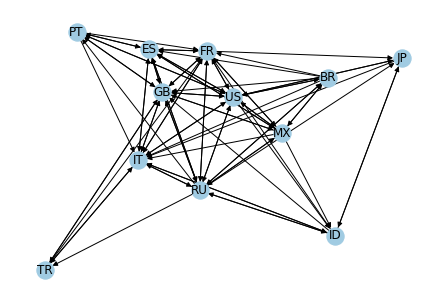

In [682]:
G = nx.ego_graph(realG_list[2], 'RU')
pos = nx.spring_layout(G)
# colors = range(1)
nx.draw(G, pos, node_color='#A0CBE2', 
#         edge_color=colors,
        width=1, edge_cmap=plt.cm.Blues, with_labels=True)

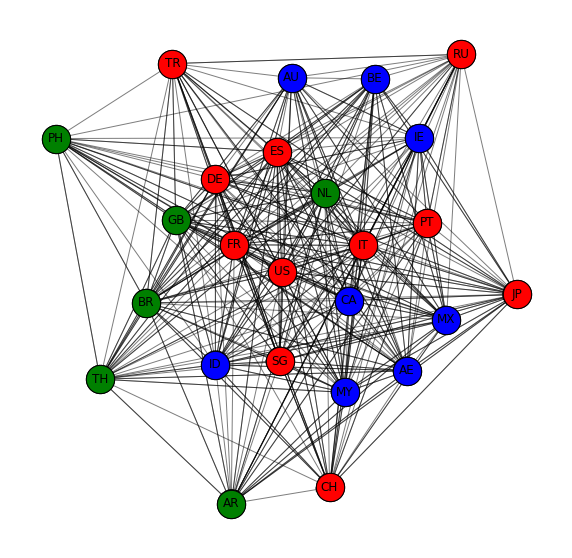

In [780]:
G = predG_list[2]
coms = predcoms_list[2]
pos = nx.spring_layout(G)
viz.plot_network_clusters(G, coms, pos, figsize=(10, 10), plot_labels=True, node_size=800)

In [768]:
coms.communities

[['US', 'FR', 'ES', 'IT', 'DE', 'JP', 'SG', 'CH', 'PT', 'TR', 'RU'],
 ['MX', 'CA', 'ID', 'MY', 'BE', 'AE', 'AU', 'IE'],
 ['GB', 'NL', 'BR', 'TH', 'PH', 'AR']]

In [730]:
nx.betweenness_centrality(G)

{'US': 0.012067586316307543,
 'GB': 0.011983419512191892,
 'FR': 0.01102596666854979,
 'ES': 0.013908369059424046,
 'IT': 0.01600364120344939,
 'DE': 0.007410066193633969,
 'MX': 0.011242704469207027,
 'CA': 0.008317438576389984,
 'JP': 0.011661774393551887,
 'NL': 0.011901082896926886,
 'BR': 0.012128587436292039,
 'TH': 0.00838204492296564,
 'ID': 0.008663707852486624,
 'MY': 0.009947991201987364,
 'SG': 0.006801954232420985,
 'BE': 0.004512511294001064,
 'AE': 0.008875398365487881,
 'AU': 0.00759589482815186,
 'CH': 0.009796799534651197,
 'PH': 0.005868366146499138,
 'IE': 0.009411675192525577,
 'PT': 0.007111209424988198,
 'AR': 0.006436580641344069,
 'TR': 0.006350943683104808,
 'RU': 0.0044783439244756385}

In [718]:
# adjmat = nx.to_numpy_array(G)

# df = pd.DataFrame([[-1,-1,-1]])
# for i in range(adjmat.shape[0]):
#     for j in range(adjmat.shape[1]):
#         if(adjmat[i,j]==0):
#             continue
#         else:
#             a_row = pd.Series([label_dict[i], label_dict[j], adjmat[i,j]])
#             row_df = pd.DataFrame([a_row])
#             df = pd.concat([df, row_df])
# #         df = pd.DataFrame(pd.Series(i,j,adjmat[i,j]), index=range(1),columns=['from','to','weight'])
# df = df.iloc[1:,:]
# df.columns = ['Source','Target','Weight']

In [719]:
# df.to_csv("predG.csv",index=False)

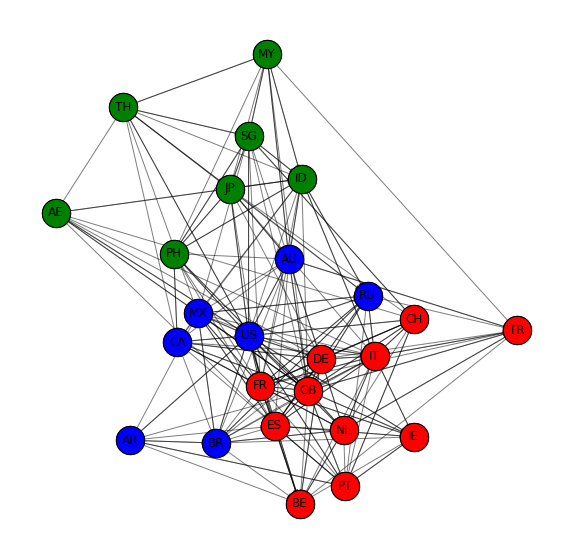

In [776]:
G = realG_list[2]
coms = realcoms_list[2]
pos = nx.spring_layout(G)
viz.plot_network_clusters(G, coms, pos, figsize=(10, 10), plot_labels=True, node_size=800)

In [777]:
coms.communities

[['GB', 'FR', 'ES', 'IT', 'DE', 'NL', 'BE', 'CH', 'IE', 'PT', 'TR'],
 ['US', 'MX', 'CA', 'BR', 'AU', 'AR', 'RU'],
 ['JP', 'TH', 'ID', 'MY', 'SG', 'AE', 'PH']]

In [778]:
nx.betweenness_centrality(G)

{'US': 0.16948937175120038,
 'GB': 0.11207368561508588,
 'FR': 0.049104246167065865,
 'ES': 0.024844374360838556,
 'IT': 0.03820020204291304,
 'DE': 0.026017476620897338,
 'MX': 0.015289973713886755,
 'CA': 0.013207384403036579,
 'JP': 0.01748947657675279,
 'NL': 0.01211144505182229,
 'BR': 0.013552902411598065,
 'TH': 0.008499695991703663,
 'ID': 0.022464596565459734,
 'MY': 0.006763285024154589,
 'SG': 0.01754003314105616,
 'BE': 0.004702015979189892,
 'AE': 0.006252156659765355,
 'AU': 0.021887220036996245,
 'CH': 0.008237361973775016,
 'PH': 0.01062686026320937,
 'IE': 0.001074016563146998,
 'PT': 0.008927741944046292,
 'AR': 0.0027831694271911664,
 'TR': 0.01066895357176687,
 'RU': 0.019496701969528053}

In [781]:
adjmat = nx.to_numpy_array(G)

df = pd.DataFrame([[-1,-1,-1]])
for i in range(adjmat.shape[0]):
    for j in range(adjmat.shape[1]):
        if(adjmat[i,j]==0):
            continue
        else:
            a_row = pd.Series([label_dict[i], label_dict[j], adjmat[i,j]])
            row_df = pd.DataFrame([a_row])
            df = pd.concat([df, row_df])
#         df = pd.DataFrame(pd.Series(i,j,adjmat[i,j]), index=range(1),columns=['from','to','weight'])
df = df.iloc[1:,:]
df.columns = ['Source','Target','Weight']
df.to_csv("pred2018.csv", index =False)